## Code of the paper titled "Improving conformalized quantile regression through cluster-based feature relevance"

---
**Authors:**
- Martim Sousa (IEETA, University of Aveiro)
- Ana Maria Tomé (IEETA, University of Aveiro)
- José Moreira (IEETA, University of Aveiro)

---

## Warning
Many of the plots and results are influenced by the inherent stochasticity of the data generation process, which can lead to minor variations in the outcome 




## 0. Setup, required libraries, helper functions

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import List, Optional
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from scipy.stats import norm
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

In [33]:
# helpers functions


def in_out(x: np.ndarray, y: np.ndarray, lower_bound: np.ndarray, upper_bound: np.ndarray):
    """
    Helper function to return four lists: the first two containing points within PIs and the last two not within PIs.
    """
    
    if len(x) != len(y) or len(x) != len(lower_bound) or len(x) != len(upper_bound):
        raise ValueError("Input arrays must have the same length")
    
    x_in = []
    x_out = []
    y_in = []
    y_out = []
    
    for i in range(len(x)):
        if y[i] >= lower_bound[i] and y[i] <= upper_bound[i]:
            x_in.append(x[i])
            y_in.append(y[i])
        else:
            x_out.append(x[i])
            y_out.append(y[i])
    
    return x_in, y_in, x_out, y_out



def plot_PIs(x_test_in: List, y_test_in: List, x_test_out: List, y_test_out: List,
            x_test: List, y_test: List, lower_bound: np.ndarray, upper_bound: np.ndarray, legend: str, plt, q_hat: Optional[float] = 0) -> None:
    """
    Helper function to make a plot of prediction intervals 
    """
    
    sorted_indices = np.argsort(x_test.flatten())
    plt.scatter(x_test_in, y_test_in, color ='black', label='Values within')
    plt.scatter(x_test_out, y_test_out, color ='red', label='Values outside')
    plt.fill_between(x_test.flatten()[sorted_indices], lower_bound[sorted_indices] - q_hat, upper_bound[sorted_indices] + q_hat, color='gray',alpha=0.3, label=f'{legend}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.ylim(min(y_test)*1.2, max(y_test) * 1.2) 
    plt.grid(True)
    
def pinball_loss(error:float, tau: float):
    """
    Computes the quantile loss
    """
    
    return max(tau*(error), (tau-1)*(error))
    

def split_data(X, y, cal_fraction, test_fraction, random_state=None):
    # Split into training + rest
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=(cal_fraction + test_fraction), random_state=random_state)

    # Split the rest into calibration and test
    test_ratio = test_fraction / (cal_fraction + test_fraction)
    X_calibration, X_test, y_calibration, y_test = train_test_split(X_rest, y_rest, test_size=test_ratio, random_state=random_state)

    return X_train, X_calibration, X_test, y_train, y_calibration, y_test


def compute_qhat_CQR(y_pred_lower, y_pred_upper, y_true, alpha):
    
    first_aux = np.array(y_pred_lower) - np.array(y_true)
    second_aux = np.array(y_true) - np.array(y_pred_upper)
    
    non_conformity_scores = np.maximum(first_aux, second_aux)
    qhat = np.quantile(non_conformity_scores, 1-alpha)
    
    return qhat


def compute_iou(interval1, interval2):
    # Calculate the intersection of the intervals
    intersection_start = max(abs(interval1[0]), abs(interval2[0]))
    intersection_end = min(abs(interval1[1]), abs(interval2[1]))

    # Check if the intervals overlap
    if intersection_start > intersection_end:
        return 0.0  # Intervals do not overlap

    # Calculate the lengths of the intervals
    length_interval1 = abs(interval1[1]) - abs(interval1[0])
    length_interval2 = abs(interval2[1]) - abs(interval2[0])

    # Calculate the length of the intersection
    length_intersection = intersection_end - intersection_start

    # Compute the IoU
    iou = length_intersection / (length_interval1 + length_interval2 - length_intersection)
    return iou

def compute_iou_test(lower_bound, upper_bound, ground_truth_PIs):
    
    iou_list = []
    
    for i in range(len(lower_bound)):
        iou_list.append(compute_iou(ground_truth_PIs[i], [lower_bound[i],upper_bound[i]]))
    
    return np.mean(iou_list)
    

def train_cal_test_split(X, y, train_size, cal_size):
    n = X.shape[0]
    n1 = int(X.shape[0] * train_size)
    n2 = int(X.shape[0] * cal_size)

        
    X_train = X[:n1]
    X_cal = X[n1:n1+n2]
    X_test = X[n1+n2:]
    
    y_train = y[:n1]
    y_cal = y[n1:n1+n2]
    y_test = y[n1+n2:]
    
    return X_train, y_train, X_cal, y_cal, X_test, y_test, (n1,n2)

def compute_coverage(y_lower_arr, y_upper_arr, y_true_arr):
    count = 0
    
    for i in range(len(y_true_arr)):
        if y_lower_arr[i] < y_true_arr[i] and y_true_arr[i] < y_upper_arr[i]:
            count+=1
    
    return count/len(y_true_arr)


def permutation_importance(model_lower, model_upper, X_cal, y_cal, n_repeats):
    lower_bound = model_lower.predict(X_cal)
    upper_bound = model_upper.predict(X_cal)
    baseline_coverage = compute_coverage(lower_bound, upper_bound, y_cal)
    
    permutation_importances = np.zeros(X_cal.shape[1])
    
    for j in range(X_cal.shape[1]):
        aux = np.zeros(n_repeats)
        
        for i in range(n_repeats):
            
            X_cal_permuted = X_cal.copy()  # Create a copy to preserve the original array
            X_cal_permuted[:, j] = np.random.permutation(X_cal_permuted[:, j])
            
            lower_bound = model_lower.predict(X_cal_permuted)
            upper_bound = model_upper.predict(X_cal_permuted)
            permuted_coverage = compute_coverage(lower_bound, upper_bound, y_cal)
            aux[i] = np.abs(baseline_coverage - permuted_coverage)
        
        permutation_importances[j] = np.mean(aux)
        
    return permutation_importances


def optimized_kmeans(X_cal,desired_variance,feature_importance):
    
    scores=[]
    
    mean_point = np.mean(X_cal*feature_importance,axis=0)
    SSE = np.sum((X_cal*feature_importance-mean_point)**2)
    i=1
    
    variance=0
    
    while variance < desired_variance:
        km = KMeans(n_clusters=i+1, random_state=0, n_init = 10).fit(X_cal*feature_importance)
        
        centroids = km.cluster_centers_
        
        clusters = km.labels_
        
        SSE_between=0
        
        for j in range(len(np.unique(clusters))):
            n_k = X_cal[clusters==j,:].shape[0]
            
            SSE_between+= n_k*np.sum((centroids[j]-mean_point)**2)
        
        variance = SSE_between/SSE
        
        scores.append([i+1,variance])
        i+=1
    
    scores = np.array(scores)
    
    best_k = i
    plt.axvline(x=best_k, color='r', linestyle='--')
    plt.plot(scores[:,0],scores[:,1])
    plt.xlabel('#clusters')
    plt.ylabel('Explained variance')
    plt.show()
    
    km =  KMeans(n_clusters=i, random_state=0, n_init = 100).fit(X_cal*feature_importance)
    
    return km,best_k


def compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, desired_variance, alpha=0.1):
    
    lower_bound = model_lower.predict(X_cal)
    upper_bound = model_upper.predict(X_cal)
    
    feature_importance = permutation_importance(model_lower, model_upper, X_cal, y_cal, 10)
    km,best_k=optimized_kmeans(X_cal, desired_variance, feature_importance)
    
    nrows = X_cal.shape[0]
    clusters = km.predict(X_cal*feature_importance)

    scores=[]
    qhats = np.zeros(best_k)

    for i in range(best_k):
        scores.append([])

    for i in range(nrows):
        scores[clusters[i]].append(max(lower_bound[i]-y_cal[i],y_cal[i]-upper_bound[i]))


    for i in range(best_k):
        N = len(scores[i])
        
        if N>0:
            qhats[i] = np.quantile(scores[i],1-alpha)
    
    return qhats,km, feature_importance



    



## Generating Figure 1

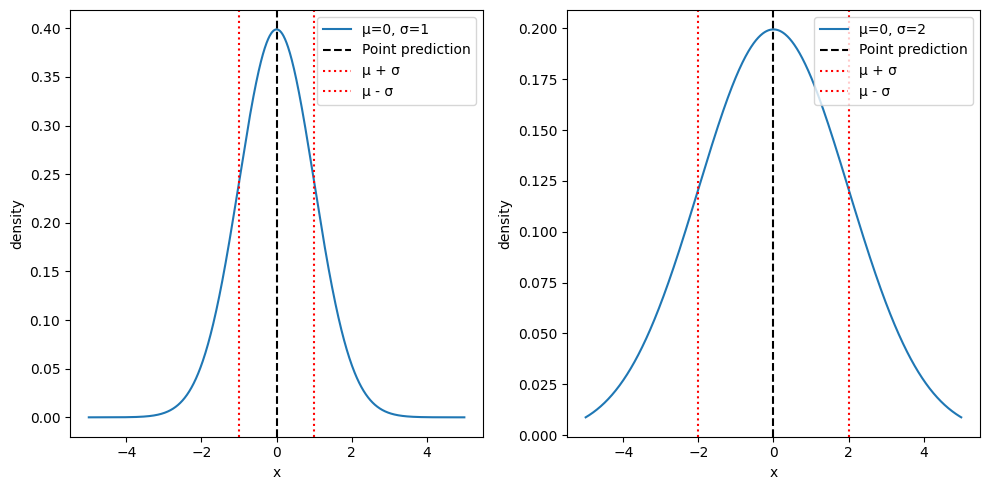

In [3]:
mu1, sigma1 = 0, 1  
mu2, sigma2 = 0, 2  
x = 0  

x_vals = np.linspace(-5, 5, 1000)

pdf1 = norm.pdf(x_vals, mu1, sigma1)
pdf2 = norm.pdf(x_vals, mu2, sigma2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x_vals, pdf1, label=f'μ={mu1}, σ={sigma1}')
plt.axvline(x=mu1, color='black', linestyle='--', label='Point prediction')
plt.axvline(x=mu1 + sigma1, color='red', linestyle=':', label='μ + σ')
plt.axvline(x=mu1 - sigma1, color='red', linestyle=':', label='μ - σ')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')

plt.subplot(1, 2, 2)
plt.plot(x_vals, pdf2, label=f'μ={mu2}, σ={sigma2}')
plt.axvline(x=mu2, color='black', linestyle='--', label='Point prediction')
plt.axvline(x=mu1 + sigma2, color='red', linestyle=':', label='μ + σ')
plt.axvline(x=mu1 - sigma2, color='red', linestyle=':', label='μ - σ')
plt.xlabel('x')
plt.ylabel('density')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Generating Figures 2 and 3

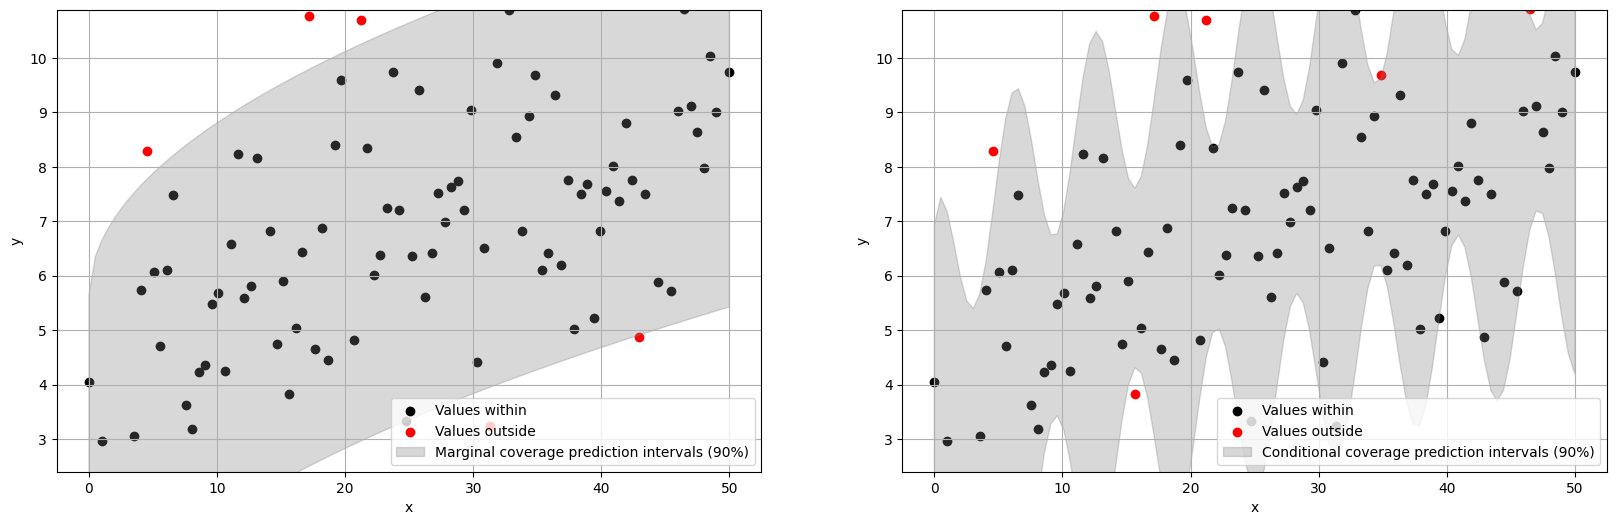

In [4]:
# params
plt.figure(figsize=(20, 6))
N = 100 # number of samples
alpha = 0.1 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2) # Get the multiplier coefficient 

# data generation
x = np.linspace(0,50,N)
y = np.zeros(N)
epsilon = np.zeros(N)
std = np.zeros(N)

for i in range(N):
    y[i] = 2 + np.sqrt(x[i])
    epsilon[i] = np.random.normal(0, 2 + np.cos(x[i]))
    std[i] = 2 + np.cos(x[i])

# marginal coverage plot
lower_bound = y - np.quantile(np.abs(epsilon), 1- alpha)
upper_bound = y + np.quantile(np.abs(epsilon), 1- alpha)

x_in, y_in, x_out, y_out = in_out(x,y + epsilon, lower_bound, upper_bound)

plt.subplot(1, 2, 1)
plot_PIs(x_in, y_in, x_out, y_out,
            x, y, lower_bound, upper_bound, "Marginal coverage prediction intervals (90%)", plt)

# conditional coverage plot
lower_bound = y - inv_cdf*std
upper_bound = y + inv_cdf*std

x_in, y_in, x_out, y_out = in_out(x, y + epsilon, lower_bound, upper_bound)
plt.subplot(1, 2, 2)
plot_PIs(x_in, y_in, x_out, y_out,
            x, y, lower_bound, upper_bound, "Conditional coverage prediction intervals (90%)", plt)

## Generating Figure 4

### Naive Inductive Conformal Prediction Regression steps

1. Train a point prediction model $\hat{f}:\mathbb{R}^d \rightarrow \mathbb{R}$ estimating the conditional mean on a training dataset $\mathcal{D}_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Define the score function as $s(x,y)= |\hat{f}(x)-y|$
3. For every $(x_i,y_i) \in \mathcal{D}_{cal}$, compute $\epsilon_i=s(x_i,y_i)$, where $\mathcal{D}_{cal}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal}}$ is the calibration data set.
4. Compute $\hat{q}= \text{Quantile}(\epsilon_1,...,\epsilon_{n_{cal}};1-\alpha)$ quantile of the calibration scores $\epsilon_1 = s(x_1, y_1), ..., \epsilon_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Deploy PIs for a nominal coverage of $1-\alpha$ as
\begin{equation}
[\hat{f}(x_i)- \hat{q},\hat{f}(x_i)+ \hat{q}]
\end{equation}

**Drawback:** This guarantees coverage property, however, the forecast interval dimension is independent of x and its dimension is allways $2\hat{q}$.


In [5]:
N = 100000 # number of samples
alpha = 0.01 # miscoverage rate
# Get the multiplier coefficient 
inv_cdf = norm.ppf(1-alpha/2)

X = np.linspace(0,10,N)
y = np.zeros(N)

for i in range(N):
    y[i] = 2 + np.sqrt(X[i]) + np.random.normal(0,0.1+ 0.1*X[i]**2)

# Split the data into training set and combined calibration/testing set
X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.49, 0.49, random_state=None)


# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 100)
model_mean = GradientBoostingRegressor(loss='quantile', alpha=0.5, n_estimators = 100)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 100)

X_train = X_train.reshape(-1,1)
X_cal = X_cal.reshape(-1,1)
X_test = X_test.reshape(-1,1)

X_test_ind = np.random.choice([i for i in range(X_test.shape[0])], 1000, replace=False)
X_test = X_test[X_test_ind]
y_test = y_test[X_test_ind]

model_lower.fit(X_train,y_train)
model_mean.fit(X_train,y_train)
model_upper.fit(X_train, y_train)



Training set shapes: X_train = (2000,) y_train = (2000,)
Calibration set shapes: X_calib = (49000,) y_calib = (49000,)
Testing set shapes: X_test = (49000,) y_test = (49000,)


GradientBoostingRegressor(alpha=0.995, loss='quantile')

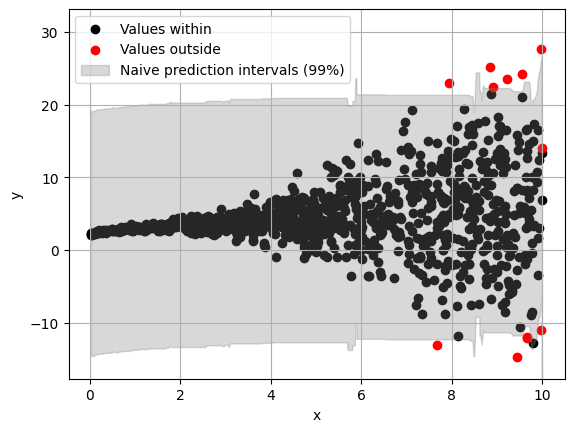

In [6]:
y_cal_pred = model_mean.predict(X_cal)
q_hat = np.quantile(np.abs(y_cal-y_cal_pred), 1-alpha)

lower_bound_test = model_mean.predict(X_test) - q_hat
upper_bound_test = model_mean.predict(X_test) + q_hat

x_in, y_in, x_out, y_out = in_out(X_test.flatten(), y_test, lower_bound_test, upper_bound_test)
plot_PIs(x_in, y_in, x_out, y_out,
            X_test, y_test, lower_bound_test, upper_bound_test, "Naive prediction intervals (99%)", plt)

## Generating Figure 5

* Pinball loss: $\rho_{\tau}(y,\hat{f}(x))=\max\left( \tau(y-\hat{f}(x)),  (\tau-1)(y-\hat{f}(x))\right), \quad \tau \in (0,1)$

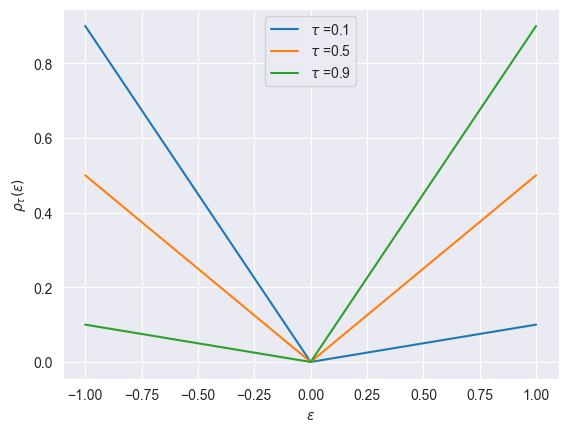

In [47]:
epsilon = np.linspace(-1,1,1000)
tau = [0.1, 0.5, 0.9]
rho_tau_01, rho_tau_05, rho_tau_09 = [], [], []

for i in range(len(epsilon)):
    rho_tau_01.append(pinball_loss(epsilon[i],0.1))
    rho_tau_05.append(pinball_loss(epsilon[i],0.5))
    rho_tau_09.append(pinball_loss(epsilon[i],0.9))

sns.set_style("darkgrid")
plt.plot(epsilon, rho_tau_01, label ='$\\tau$ =0.1')
plt.plot(epsilon, rho_tau_05, label ='$\\tau$ =0.5')    
plt.plot(epsilon, rho_tau_09, label ='$\\tau$ =0.9')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\rho_{\\tau}(\epsilon)$')
plt.grid(True)
plt.legend()

## Generating Figures 6 and 7

**Quantile Regression**

* We seek to estimate the conditional populational quantile: $Q_{\tau}(x)=\inf{\{y \in \mathcal{Y}:F_{Y|X}(y|x) \ge \tau}\}$;
* We'll refer to these estimates as $\hat{Q}_{\tau}(x)$;
* Estimates are consistently asymptoticaly under regularity condition.

Steps:

1. Estimate $\hat{Q}_{\alpha/2}(x)$ and $\hat{Q}_{1-\alpha/2}(x)$ through $\mathcal{D}_{train}$ by minimizing the pinball loss;
2. Deploy prediction intervals as: $\hat{C}_{1-\alpha}(x) = [\hat{Q}_{\alpha/2}(x), \hat{Q}_{1-\alpha/2}(x)]$

**Note**: While quantile regression captures heteroscedasticity, its PIs may not be valid.

**Conformalized Quantile Regression**

Steps:

1. Estimate $\hat{Q}_{\alpha/2}(x)$ and $\hat{Q}_{1-\alpha/2}(x)$ through $\mathcal{D}_{train}$ by minimizing the pinball loss;
2. $s(x,y)=\max{\{\hat{Q}_{\alpha/2}(x)-y,y-\hat{Q}_{1-\alpha/2}(x)\}}.$
3. For every $(x_i,y_i) \in \mathcal{D}_{cal}$, compute $\epsilon_i=s(x_i,y_i)$, where $\mathcal{D}_{cal}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal}}$ is the calibration data set.
4. Compute $\hat{q}= \text{Quantile}(\epsilon_1,...,\epsilon_{n_{cal}};1-\alpha)$ quantile of the calibration scores $\epsilon_1 = s(x_1, y_1), ..., \epsilon_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Deploy PIs for a nominal coverage of $1-\alpha$ as
\begin{equation}
\hat{C}_{1-\alpha}(x) = [\hat{Q}_{\alpha/2}(x)- \hat{q},\hat{Q}_{1-\alpha/2}(x)+ \hat{q}]
\end{equation}


**Improved Conformalized Quantile Regression**

Steps:

1. Estimate $\hat{Q}_{\alpha/2}(x)$ and $\hat{Q}_{1-\alpha/2}(x)$ through $\mathcal{D}_{train}$ by minimizing the pinball loss;
2. Get permutation scores $I_1,...,I_d$;
3. Apply K-means on $X_{cal} * (I_1,..,I_d)$ to get k centroids $c_1,...c_k$
4. Get $\hat{q}^\{(i)\} \quad i \in\{1,...,k\}$ 
5. Deploy PIs for a nominal coverage of $1-\alpha$ as
\begin{equation}
\hat{C}_{1-\alpha}(x) = [\hat{Q}_{\alpha/2}(x)- \hat{q}^{(i)},\hat{Q}_{1-\alpha/2}(x)+ \hat{q}^{(i)}]
\end{equation}
considering $c_i$ is the closest centroid to $x * (I_1,..,I_d)$



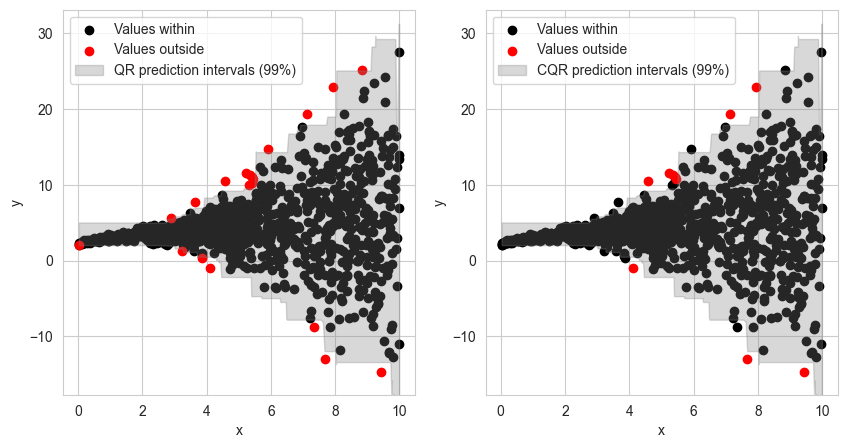

In [53]:
sns.set_style("whitegrid")
lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
x_in, y_in, x_out, y_out = in_out(X_test.flatten(), y_test, lower_bound_test, upper_bound_test)
plot_PIs(x_in, y_in, x_out, y_out,
            X_test, y_test, lower_bound_test, upper_bound_test, "QR prediction intervals (99%)", plt)

plt.subplot(1, 2, 2)
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)

x_in, y_in, x_out, y_out = in_out(X_test.flatten(), y_test, lower_bound_test- q_hat, upper_bound_test + q_hat)
plot_PIs(x_in, y_in, x_out, y_out,
            X_test, y_test, lower_bound_test, upper_bound_test, "CQR prediction intervals (99%)", plt)

## Figure 8 (LaTeX)

## Generating Figures 9 and 10

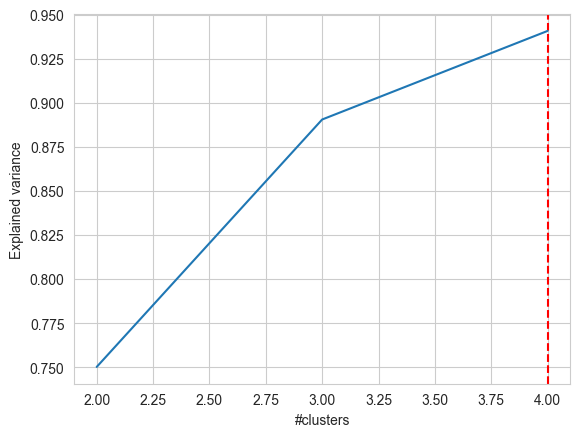

In [61]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, 0.01)

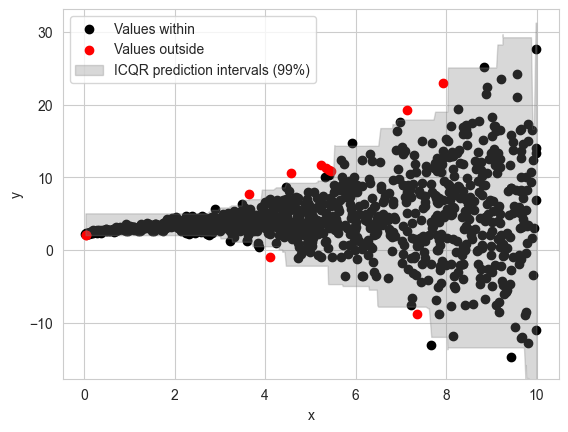

In [73]:
ind_qhats = km.predict(X_test*permutation_scores)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)

x_in, y_in, x_out, y_out = in_out(X_test.flatten(), y_test, lower_bound_test-q_hat_list, upper_bound_test+q_hat_list)
plot_PIs(x_in, y_in, x_out, y_out,
            X_test, y_test, lower_bound_test, upper_bound_test, "ICQR prediction intervals (99%)", plt)

## Replicating experiments

$\begin{align}
& Y = 0.8X_1 + 0.1X_2 + \mathcal{N}(0, 0.5+(X_1 + X_2)/2), \quad X_1,X_2 \sim \beta(2,2)  \label{eq1}\\
&Y = 0.5\sin{(2\pi X_1)} + 0.2X_2 + \mathcal{N}(0, 0.1 + 0.4X_1), \quad X_1,X_2 \sim \beta(1,3) \label{eq2}\\
&Y = \sqrt{X_1^2+X_2^2} + X_1 + \mathcal{N}(0, 0.6+0.5X_2^2), \quad X_1,X_2 \sim \beta(2,3) \label{eq3} \\
& Y = \sqrt{X_1^2+X_1X_2} + \mathcal{N}(0, 0.6X_1^2+ 0.5X_2^2), \quad
X_1 \sim U(0,2) \text{ and } X_2 \sim \beta(2,2) \label{eq4}
\end{align}$

In [84]:
N = 100000 # number of samples
X = np.random.beta(2, 2, size=(N, 2)) # data generation

In [128]:
alpha = 0.1 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.5 + (X[i,0]+X[i,1])/2
    mu = 0.8*X[i,0] +0.1*X[i,1]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.95, loss='quantile', n_estimators=1000)

In [129]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

In [134]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.1, Coverage: 0.9, MIOU: 0.45422739696898606'

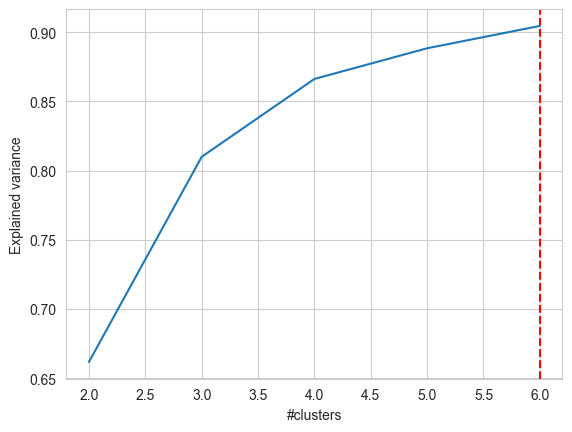

'Results for CQR with alpha=0.1, Coverage: 0.89748, MIOU: 0.4469252401188398'

In [136]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test*feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

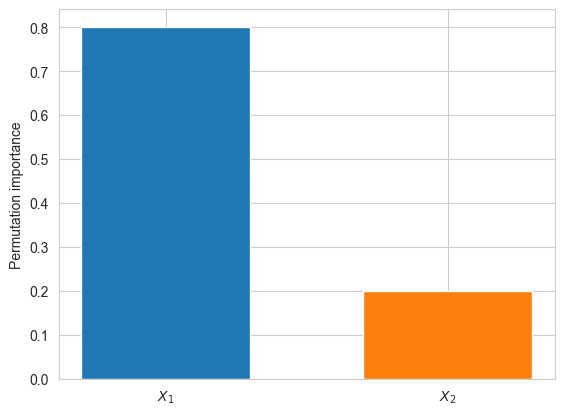

In [139]:
feature_importance = feature_importance/np.sum(feature_importance)
categories = ['$X_1$', '$X_2$']
index = [0,0.5]

plt.bar(0, feature_importance[0], width=0.3)
plt.bar(0.5, feature_importance[1], width=0.3)
plt.xticks(index, categories)
plt.ylabel('Permutation importance')

plt.show()

In [141]:
alpha = 0.05 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.5 + (X[i,0]+X[i,1])/2
    mu = 0.8*X[i,0] +0.1*X[i,1]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.975, loss='quantile', n_estimators=1000)

In [142]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.05, Coverage: 0.92396, MIOU: 0.468469245133818'

In [143]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.05, Coverage: 0.95, MIOU: 0.48026584724541493'

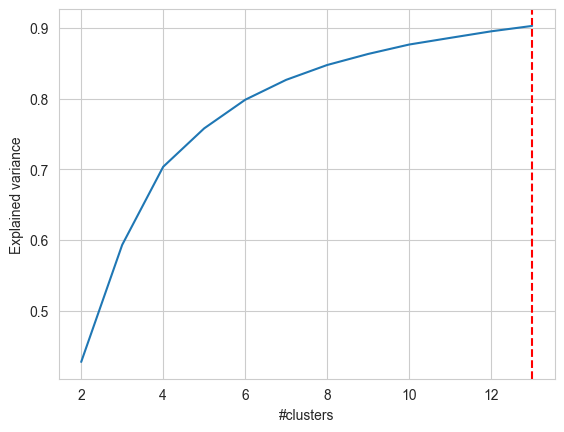

'Results for ICQR with alpha=0.05, Coverage: 0.95082, MIOU: 0.44924057833302633'

In [146]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

In [147]:
alpha = 0.01 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.5 + (X[i,0]+X[i,1])/2
    mu = 0.8*X[i,0] +0.1*X[i,1]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.995, loss='quantile', n_estimators=1000)

In [148]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.01, Coverage: 0.96312, MIOU: 0.2506246267858053'

In [150]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.01, Coverage: 0.99, MIOU: 0.33545800104384643'

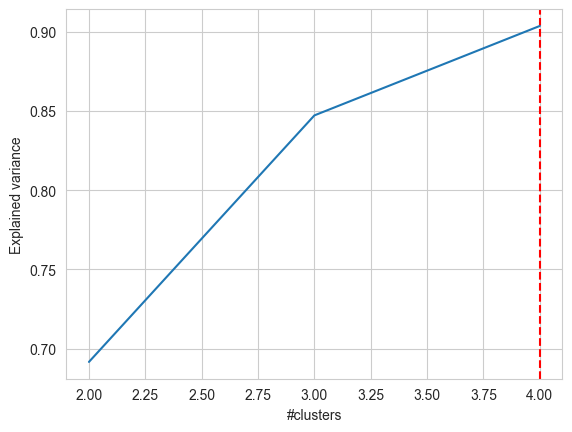

'Results for ICQR with alpha=0.01, Coverage: 0.98966, MIOU: 0.33519680794615203'

In [151]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

## 2nd Dataset

In [152]:
N = 100000 # number of samples
X = np.random.beta(1, 3, size=(N, 2)) # data generation

In [153]:
alpha = 0.1 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.1 + 0.4*X[i,0]
    mu = 0.5*np.sin(2*np.pi*X[i,0]) + 0.2* X[i,1]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.95, loss='quantile', n_estimators=1000)

In [154]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.1, Coverage: 0.87692, MIOU: 0.40349241289093674'

In [155]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.1, Coverage: 0.9, MIOU: 0.40701888417385423'

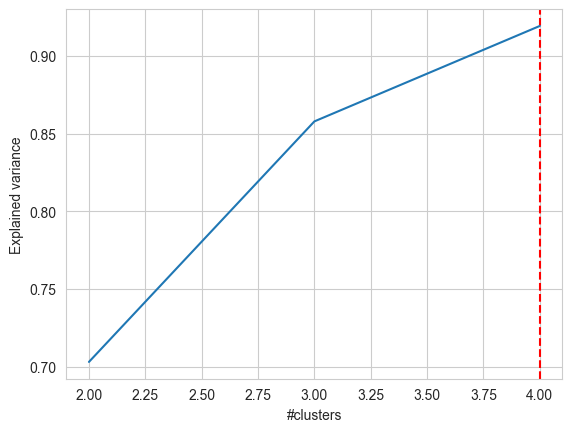

'Results for ICQR with alpha=0.1, Coverage: 0.90102, MIOU: 0.40503636379564306'

In [156]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

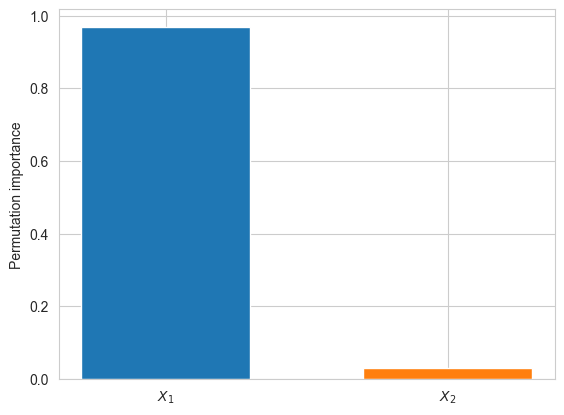

In [157]:
feature_importance = feature_importance/np.sum(feature_importance)
categories = ['$X_1$', '$X_2$']
index = [0,0.5]

plt.bar(0, feature_importance[0], width=0.3)
plt.bar(0.5, feature_importance[1], width=0.3)
plt.xticks(index, categories)
plt.ylabel('Permutation importance')

plt.show()

In [158]:
alpha = 0.05 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.1 + 0.4*X[i,0]
    mu = 0.5*np.sin(2*np.pi*X[i,0]) + 0.2* X[i,1]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.975, loss='quantile', n_estimators=1000)

In [159]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.05, Coverage: 0.91982, MIOU: 0.4022939797403484'

In [160]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.05, Coverage: 0.95, MIOU: 0.4095907189573657'

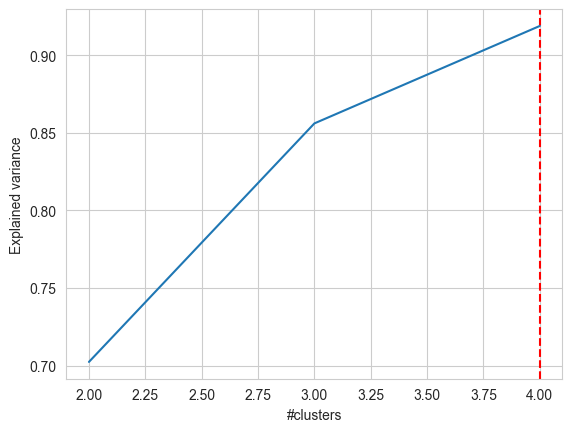

'Results for ICQR with alpha=0.05, Coverage: 0.95044, MIOU: 0.40908106110742665'

In [161]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

In [162]:
alpha = 0.01 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.1 + 0.4*X[i,0]
    mu = 0.5*np.sin(2*np.pi*X[i,0]) + 0.2* X[i,1]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.995, loss='quantile', n_estimators=1000)

In [163]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.01, Coverage: 0.98156, MIOU: 0.41519581578597375'

In [164]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.01, Coverage: 0.99, MIOU: 0.38706392009815777'

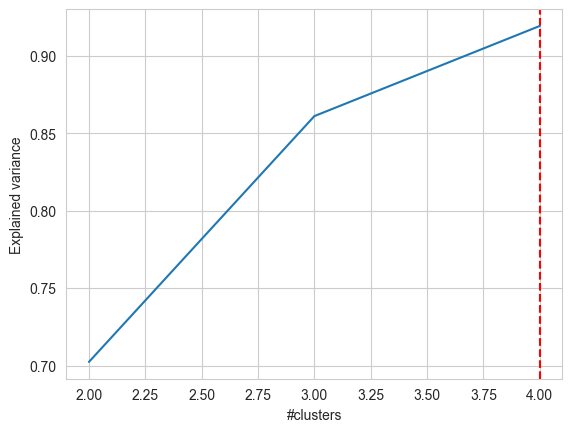

'Results for ICQR with alpha=0.01, Coverage: 0.98988, MIOU: 0.3940831254694694'

In [165]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

## 3rd dataset

In [166]:
N = 100000 # number of samples
X = np.random.beta(2, 3, size=(N, 2)) # data generation

In [169]:
alpha = 0.1 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.6 + 0.5*X[i,1]**2
    mu = np.sqrt(X[i,0]**2+ X[i,1]**2) + X[i,0]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.95, loss='quantile', n_estimators=1000)

In [170]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.1, Coverage: 0.85158, MIOU: 0.6657239203353977'

In [171]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.1, Coverage: 0.9, MIOU: 0.6770691564387683'

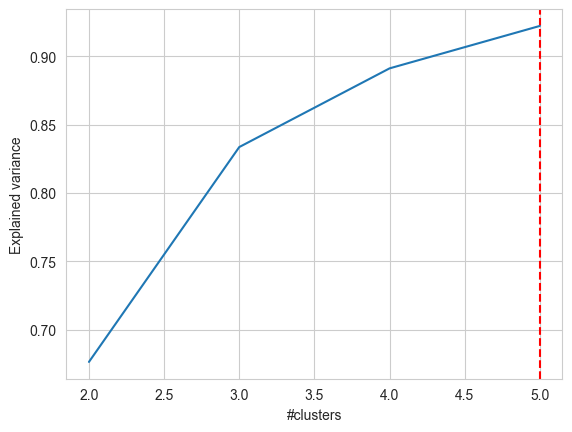

'Results for ICQR with alpha=0.1, Coverage: 0.8997, MIOU: 0.683310029957624'

In [172]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

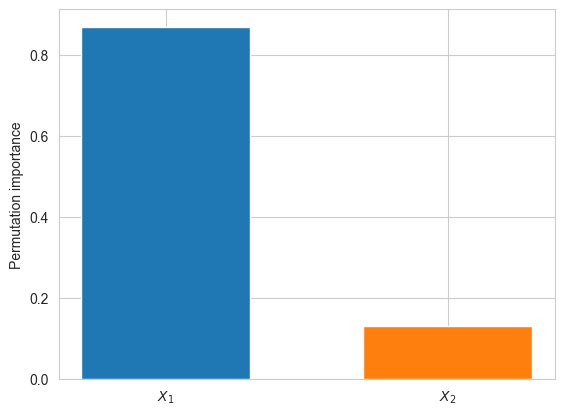

In [173]:
feature_importance = feature_importance/np.sum(feature_importance)
categories = ['$X_1$', '$X_2$']
index = [0,0.5]

plt.bar(0, feature_importance[0], width=0.3)
plt.bar(0.5, feature_importance[1], width=0.3)
plt.xticks(index, categories)
plt.ylabel('Permutation importance')

plt.show()

In [174]:
alpha = 0.05 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.6 + 0.5*X[i,1]**2
    mu = np.sqrt(X[i,0]**2+ X[i,1]**2) + X[i,0]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.975, loss='quantile', n_estimators=1000)

In [175]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.05, Coverage: 0.92054, MIOU: 0.6610074162710265'

In [176]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.05, Coverage: 0.95, MIOU: 0.6538804783984037'

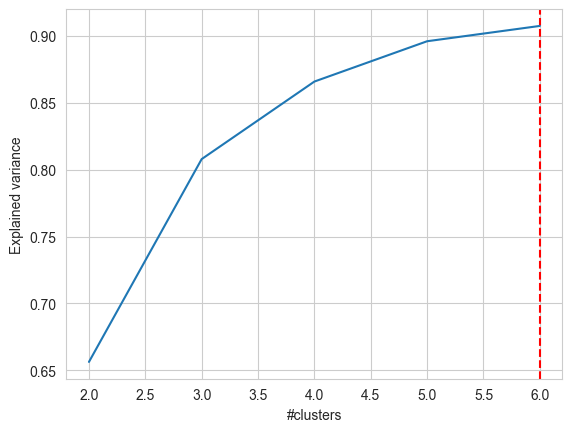

'Results for ICQR with alpha=0.05, Coverage: 0.94684, MIOU: 0.6542350256959769'

In [177]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

In [179]:
alpha = 0.01 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.6 + 0.5*X[i,1]**2
    mu = np.sqrt(X[i,0]**2+ X[i,1]**2) + X[i,0]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.995, loss='quantile', n_estimators=1000)

In [180]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for QR with alpha=0.01, Coverage: 0.9685, MIOU: 0.6483804988939892'

In [181]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.01, Coverage: 0.99, MIOU: 0.6553806807309887'

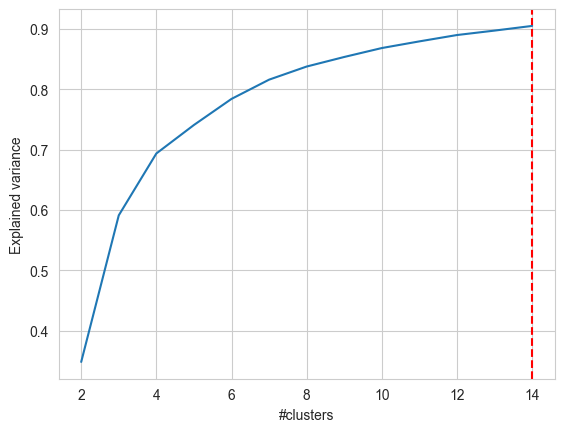

'Results for ICQR with alpha=0.01, Coverage: 0.98974, MIOU: 0.6479628693163949'

In [182]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

## Last dataset

In [184]:
N = 100000 # numberof samples
X_1 = np.random.uniform(0, 2, size=(N, 1))
X_2 = np.random.beta(2, 2, size=(N, 1))

In [186]:
alpha = 0.1 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.6*X_1[i]**2 + 0.5*X[i,1]**2
    mu = np.sqrt(X_1[i]**2+ X[i,1]*X[i,0]) + X[i,0]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.95, loss='quantile', n_estimators=1000)

In [187]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

C:\Users\marti\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


'Results for QR with alpha=0.1, Coverage: 0.8558, MIOU: [0.46269999]'

In [188]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.1, Coverage: 0.9, MIOU: [0.46577872]'

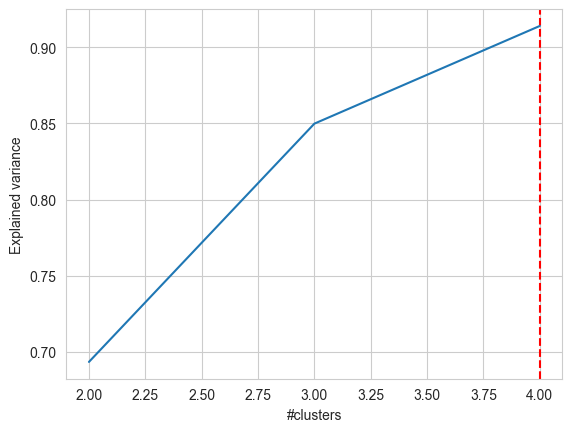

C:\Users\marti\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


'Results for ICQR with alpha=0.1, Coverage: 0.90082, MIOU: [0.46498153]'

In [189]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

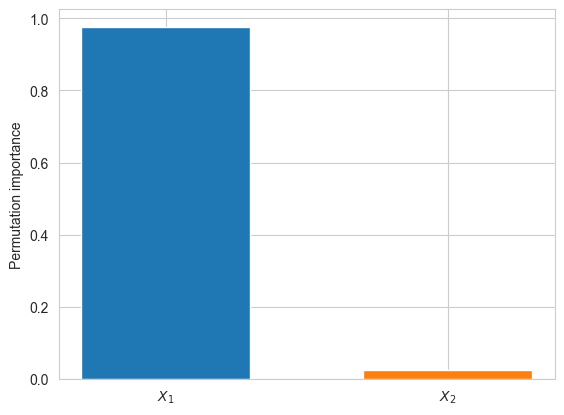

In [190]:
feature_importance = feature_importance/np.sum(feature_importance)
categories = ['$X_1$', '$X_2$']
index = [0,0.5]

plt.bar(0, feature_importance[0], width=0.3)
plt.bar(0.5, feature_importance[1], width=0.3)
plt.xticks(index, categories)
plt.ylabel('Permutation importance')

plt.show()

In [191]:
alpha = 0.05 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.6*X_1[i]**2 + 0.5*X[i,1]**2
    mu = np.sqrt(X_1[i]**2+ X[i,1]*X[i,0]) + X[i,0]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.975, loss='quantile', n_estimators=1000)

In [192]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

C:\Users\marti\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


'Results for QR with alpha=0.05, Coverage: 0.92096, MIOU: [0.43826429]'

In [193]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.05, Coverage: 0.95, MIOU: [0.4229874]'

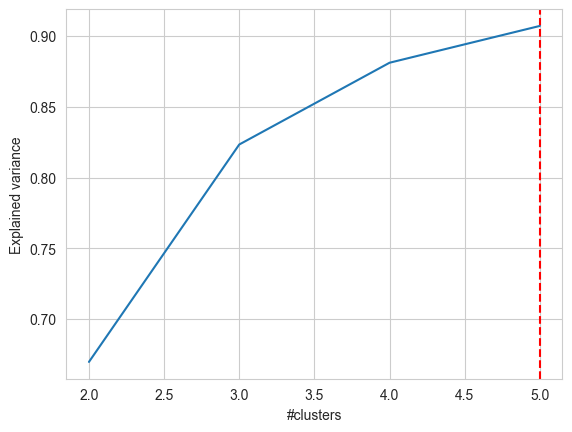

C:\Users\marti\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


'Results for ICQR with alpha=0.05, Coverage: 0.95258, MIOU: [0.42033457]'

In [194]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

In [195]:
alpha = 0.01 # miscoverage rate
inv_cdf = norm.ppf(1-alpha/2)
y = np.zeros(N)
ground_truth_PIs = []

for i in range(N):
    std = 0.6*X_1[i]**2 + 0.5*X[i,1]**2
    mu = np.sqrt(X_1[i]**2+ X[i,1]*X[i,0]) + X[i,0]
    y[i] = mu + np.random.normal(0, std)
    ground_truth_PIs.append([mu- inv_cdf*std, mu + inv_cdf*std])


X_train, X_cal, X_test, y_train, y_cal, y_test = split_data(X, y, 0.4, 0.5, random_state=None)
X_train = X_train[:1000]
y_train = y_train[:1000]

# Print the shapes of the resulting datasets
print("Training set shapes: X_train =", X_train.shape, "y_train =", y_train.shape)
print("Calibration set shapes: X_calib =", X_cal.shape, "y_calib =", y_cal.shape)
print("Testing set shapes: X_test =", X_test.shape, "y_test =", y_test.shape)

model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2, n_estimators = 1000)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2, n_estimators = 1000)


model_lower.fit(X_train,y_train)
model_upper.fit(X_train, y_train)

Training set shapes: X_train = (1000, 2) y_train = (1000,)
Calibration set shapes: X_calib = (40000, 2) y_calib = (40000,)
Testing set shapes: X_test = (50000, 2) y_test = (50000,)


GradientBoostingRegressor(alpha=0.995, loss='quantile', n_estimators=1000)

In [196]:
# quantile regression

lower_bound_test = model_lower.predict(X_test)
upper_bound_test = model_upper.predict(X_test)
coverage = compute_coverage(lower_bound_test, upper_bound_test, y_test)
miou = compute_iou_test(lower_bound_test, upper_bound_test, ground_truth_PIs)

f'Results for QR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

C:\Users\marti\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


'Results for QR with alpha=0.01, Coverage: 0.9819, MIOU: [0.34025061]'

In [197]:
# CQR
q_hat = compute_qhat_CQR(lower_bound_test, upper_bound_test, y_test, alpha)
coverage = compute_coverage(lower_bound_test- q_hat, upper_bound_test+ q_hat, y_test)
miou = compute_iou_test(lower_bound_test - q_hat, upper_bound_test + q_hat, ground_truth_PIs)

f'Results for CQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'

'Results for CQR with alpha=0.01, Coverage: 0.99, MIOU: [0.30695995]'

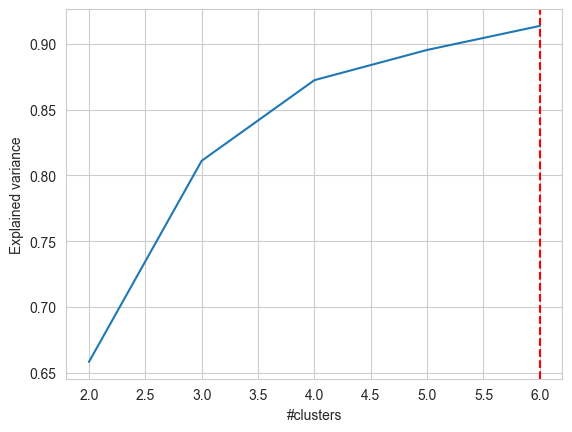

C:\Users\marti\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


'Results for ICQR with alpha=0.01, Coverage: 0.99008, MIOU: [0.30778682]'

In [198]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha)
ind_qhats = km.predict(X_test * feature_importance)
q_hat_list = []
for i in range(len(ind_qhats)):
    q_hat_list.append(qhats[ind_qhats[i]])
    
coverage = compute_coverage(lower_bound_test- q_hat_list, upper_bound_test+ q_hat_list, y_test)
miou = compute_iou_test(lower_bound_test - q_hat_list, upper_bound_test + q_hat_list, ground_truth_PIs)

f'Results for ICQR with alpha={alpha}, Coverage: {coverage}, MIOU: {miou}'